In [1]:
import tensorflow as tf

from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

import matplotlib.pyplot as plt
from IPython.display import Image

# CNN Auto-Encoder 구현

In [2]:
input_img = tf.keras.Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same', name='DecoderStart')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [3]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

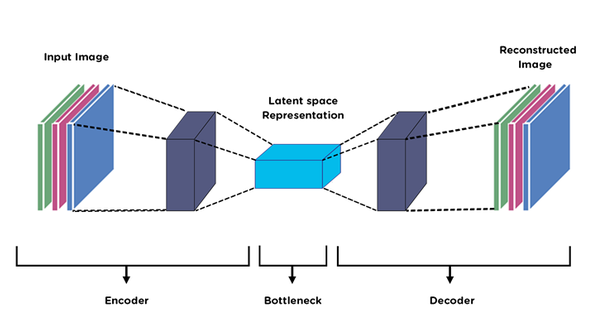

In [4]:
Image('img/autoencoder_cnn_schema.jpg')

## Encoder 부분만 떼어내기

In [5]:
# This model maps an input to its encoded representation
encoder = tf.keras.Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584 

## Decoder 부분만 떼어내기

In [6]:
encoded_input = autoencoder.get_layer(name='DecoderStart').input
decoder = tf.keras.Model(encoded_input, decoded)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 8)]         0         
                                                                 
 DecoderStart (Conv2D)       (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        1168

In [7]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

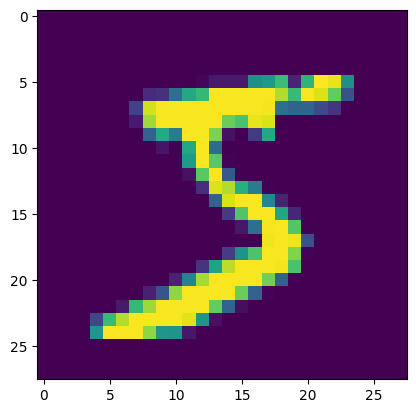

In [9]:
plt.imshow(x_train[0]/255, interpolation='nearest')
plt.show()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Model fine-tunning

In [11]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
235/235 [==============================] - 61s 248ms/step - loss: 0.2849 - val_loss: 0.1696
Epoch 2/5
235/235 [==============================] - 62s 264ms/step - loss: 0.1567 - val_loss: 0.1457
Epoch 3/5
235/235 [==============================] - 57s 241ms/step - loss: 0.1410 - val_loss: 0.1345
Epoch 4/5
235/235 [==============================] - 56s 239ms/step - loss: 0.1322 - val_loss: 0.1274
Epoch 5/5
235/235 [==============================] - 59s 250ms/step - loss: 0.1258 - val_loss: 0.1219


# Encode data

In [18]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# autoencoder.predict(x_test)

313/313 [==============================] - 5s 17ms/step


In [19]:
print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 4, 4, 8)
(10000, 28, 28, 1)


# Results

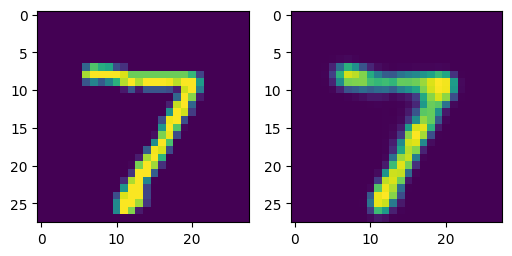

In [20]:
fig = plt.figure(figsize=(6, 3))

fig.add_subplot(1, 2, 1) # row, column, n번째 image
plt.imshow(x_test[0]/255, interpolation='nearest')

fig.add_subplot(1, 2, 2)
plt.imshow(decoded_imgs[0]/255, interpolation='nearest')

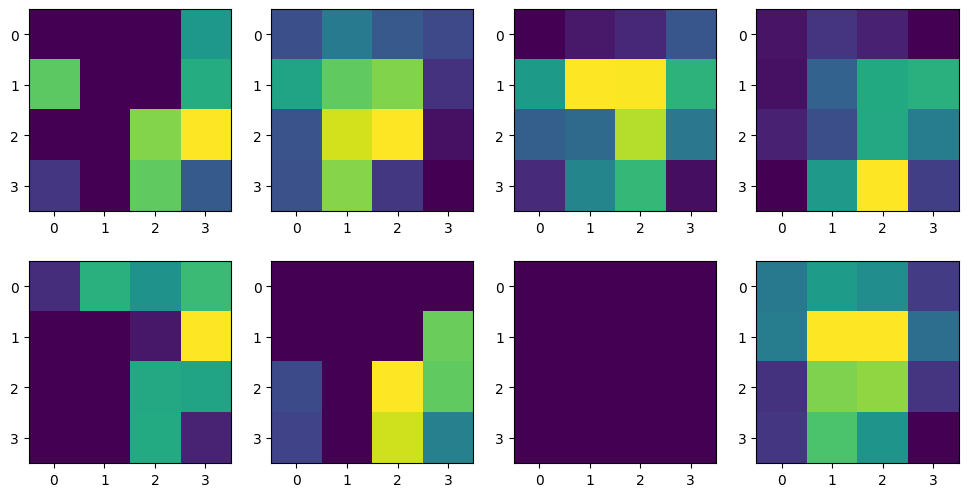

In [21]:
fig = plt.figure(figsize=(12, 6))

for i in range(8):
    fig.add_subplot(2, 4, i+1) # row, column, n번째 image
    plt.imshow(encoded_imgs[0][:,:,i]/255, interpolation='nearest')